# 1) Carregar CSV



In [10]:
install.packages(c("GGally"))
install.packages(c("plotly"))
library(tidyverse)
library(lubridate)

df_bigtech_stocks <- read_csv("stock_market_data.csv",
               col_types = cols(Date = col_date(format = "%Y-%m-%d")))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘patchwork’, ‘ggstats’, ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [11]:
head(df_bigtech_stocks)

Date,Close_AAPL,Close_AMZN,Close_GOOGL,Close_MSFT,Close_NVDA,High_AAPL,High_AMZN,High_GOOGL,High_MSFT,⋯,Open_AAPL,Open_AMZN,Open_GOOGL,Open_MSFT,Open_NVDA,Volume_AAPL,Volume_AMZN,Volume_GOOGL,Volume_MSFT,Volume_NVDA
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-04,6.440330,6.6950,15.60981,23.25405,0.4238836,6.455075,6.8305,15.67855,23.36675,⋯,6.422875,6.8125,15.61479,23.00611,0.4243421,493729600,151998000,78169752,38409100,800204000
2010-01-05,6.451465,6.7345,15.54106,23.26156,0.4300734,6.487878,6.7740,15.63695,23.36675,⋯,6.458086,6.6715,15.62051,23.17891,0.4222789,601904800,177038000,120067812,49749600,728648000
2010-01-06,6.348847,6.6125,15.14929,23.11881,0.4328243,6.477046,6.7365,15.58764,23.35172,⋯,6.451466,6.7300,15.58764,23.20146,0.4298440,552160000,143576000,158988852,58182400,649168000
2010-01-07,6.337109,6.5000,14.79662,22.87838,0.4243421,6.379842,6.6160,15.19263,23.06621,⋯,6.372319,6.6005,15.17769,23.01362,0.4305318,477131200,220604000,256315428,50559700,547792000
2010-01-08,6.379242,6.6760,14.99388,23.03617,0.4252592,6.379844,6.6840,15.02451,23.20146,⋯,6.328685,6.5280,14.74432,22.75066,0.4209034,447610800,196610000,188783028,51197400,478168000
2010-01-11,6.322966,6.5155,14.97122,22.74314,0.4192987,6.409936,6.6400,15.05465,23.11130,⋯,6.403917,6.6310,15.05465,23.07373,0.4275517,462229600,175588000,288227484,68754700,556612000


# 2) Transformação de “wide” para “long”, facilitando facetas e comparações

In [14]:
df_long <- df_bigtech_stocks %>%
  select(Date, starts_with("Close_"), starts_with("Volume_")) %>%
  pivot_longer(
    cols      = -Date,                   # pega todas menos Date
    names_to  = c("Type", "Ticker"),     # separa o nome em dois campos
    names_sep = "_"                      # no underscore (“Close_AAPL” vira Type=“Close”, Ticker=“AAPL”)
  ) %>%
  pivot_wider(
    names_from  = Type,                  # cria colunas Close, Volume
    values_from = value                  # com os respectivos valores
  )
# Por que? Um formato “long” (observação por linha) é muito mais flexível para usar faceting
# e calcular estatísticas por grupo no tidyverse.

# 3) Cálculo de retorno diário para cada ação


In [15]:
df_long <- df_long %>%
  group_by(Ticker) %>%                     # agrupa por empresa
  arrange(Date) %>%                        # ordena cronologicamente
  mutate(
    Return = (Close - lag(Close)) / lag(Close)  # (preço de hoje – ontem) / ontem
  ) %>%
  ungroup()
# Por que? Retornos percentuais padronizam a comparação entre ações de preços absolutos muito diferentes.


In [17]:
print(tail(df_long))

# A tibble: 6 × 5
  Date       Ticker Close    Volume   Return
  <date>     <chr>  <dbl>     <dbl>    <dbl>
1 2024-12-30 NVDA    137. 167734700  0.00350
2 2024-12-31 AAPL    250.  39480700 -0.00706
3 2024-12-31 AMZN    219.  24819700 -0.00863
4 2024-12-31 GOOGL   189.  17466900 -0.0101 
5 2024-12-31 MSFT    421.  13246500 -0.00784
6 2024-12-31 NVDA    134. 155659200 -0.0233 


# Visualizações & Narrativa

## Capítulo 1 – Crescimento de Preço (Time-Series Facet)
- O que faz: mostra a evolução de preço de cada ação em painéis separados.
- Por que: facilita comparar tendências de longo prazo sem que um preço alto “esmague” outro.

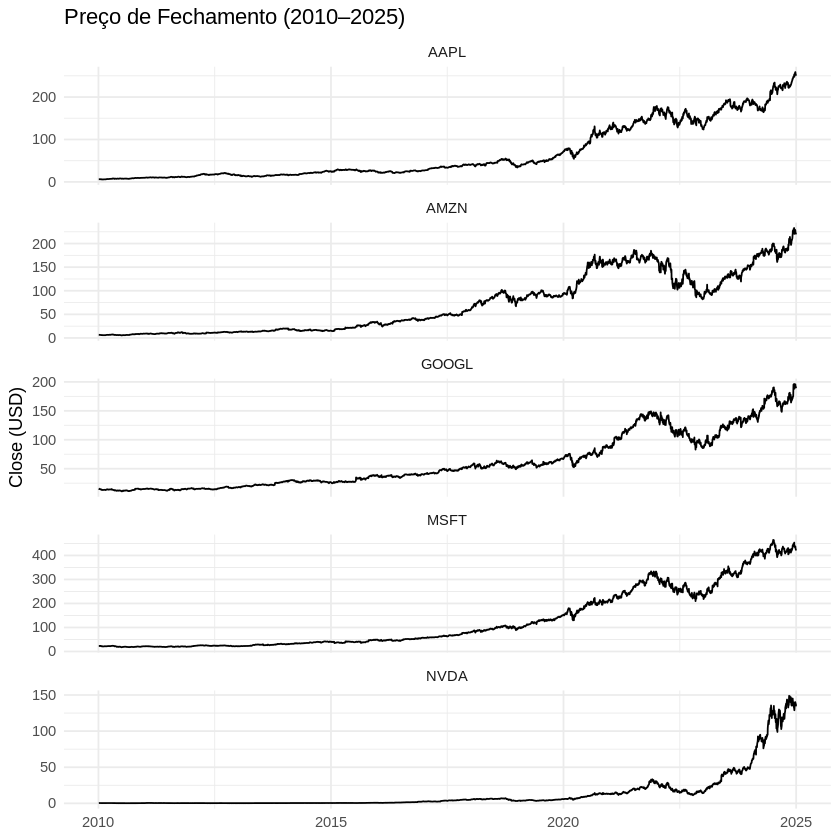

In [18]:
ggplot(df_long, aes(x = Date, y = Close)) +
  geom_line() +                             # desenha uma linha conectando pontos (série temporal)
  facet_wrap(~Ticker,                       # cria um painel para cada Ticker
             scales = "free_y",             # eixos y independentes, pois preços variam muito
             ncol   = 1) +                  # empilha um embaixo do outro
  labs(
    title = "Preço de Fechamento (2010–2025)",  # título explicativo
    x = NULL,                                    # remove label x (óbvio: data)
    y = "Close (USD)"                            # label y com unidade
  ) +
  theme_minimal()                             # tema limpo, foca no dado


# Insights
A ação da NVIDIA (NVDA) apresenta a curva de crescimento mais acentuada e recente dentre todas, destacando uma aceleração explosiva a partir de 2020, especialmente após 2022.
- Tomada de decisão para investidores: empresas com crescimento explosivo podem indicar alto retorno, mas também maior risco.

- Ciclos de mercado: momentos de correção (queda) visíveis em AMZN, GOOGL e MSFT mostram a importância da diversificação e visão de longo prazo.

# Volatilidade por Caixa (Boxplot de Retornos)
- O que faz: desenha caixas que mostram mediana, quartis e outliers de retorno.
- Por que: quantifica volatilidade e risco; caixas mais altas indicam maior dispersão.

Warning message:
“Removed 5 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


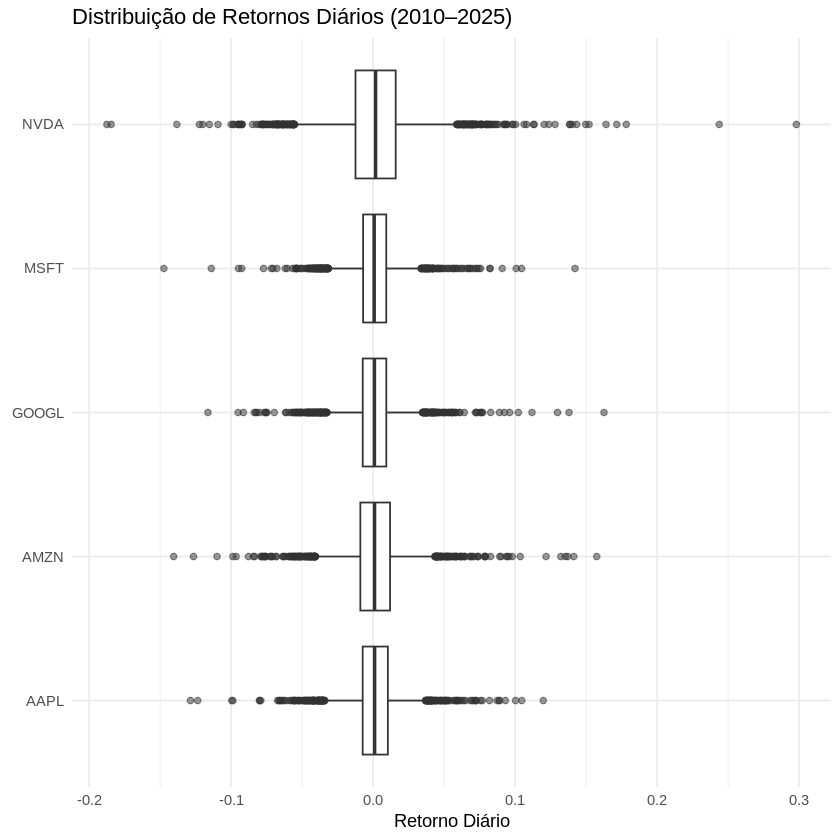

In [19]:
ggplot(df_long, aes(x = Ticker, y = Return)) +
  geom_boxplot(outlier.alpha = 0.5) +         # boxplot com outliers semi-transparentes
  coord_flip() +                              # inverte eixos para melhor leitura dos rótulos
  labs(
    title = "Distribuição de Retornos Diários (2010–2025)",
    x = NULL,
    y = "Retorno Diário"
  ) +
  theme_minimal()


# Insights
A ação da NVIDIA (NVDA) possui a maior volatilidade de retorno diário dentre todas as empresas analisadas.

# Eventos Marcantes (Zoom Interativo com Plotly)
- O que faz: gera gráfico interativo com slider de data.
- Por que: destaca eventos específicos (p.ex. março/2020)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


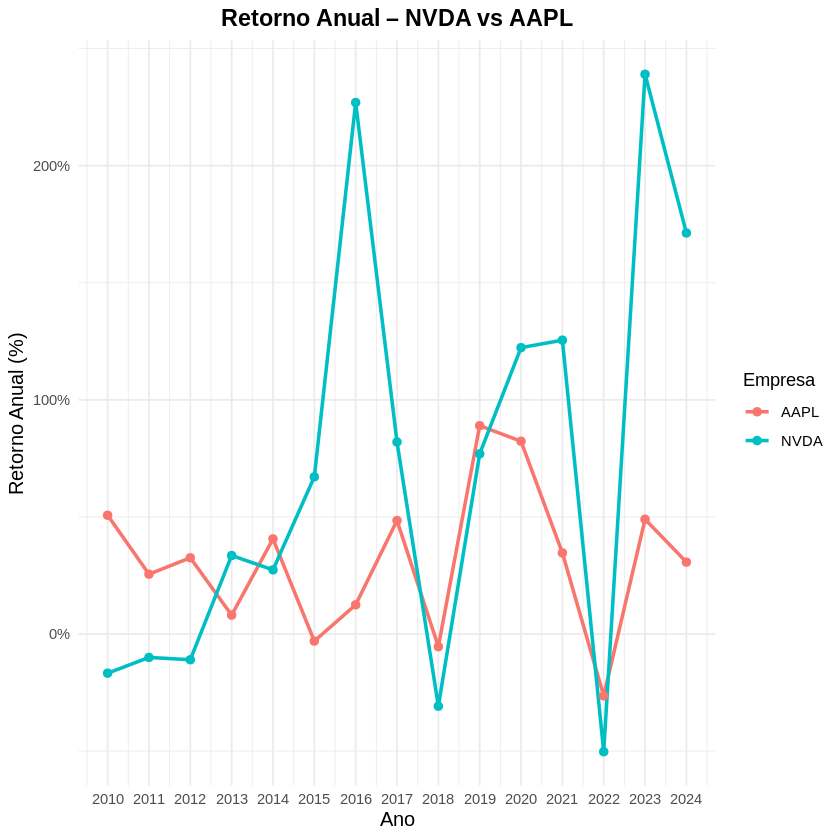

In [20]:
library(ggplot2)
library(dplyr)
library(lubridate)

# Calcula retorno anual composto por Ticker
df_annual_return <- df_long %>%
  filter(Ticker %in% c("NVDA", "AAPL"), !is.na(Return)) %>%
  mutate(Year = year(Date)) %>%
  group_by(Ticker, Year) %>%
  summarise(
    AnnualReturn = prod(1 + Return) - 1,   # Retorno composto anual
    .groups = "drop"
  )

# Gráfico de retorno anual por empresa
ggplot(df_annual_return, aes(x = Year, y = AnnualReturn, color = Ticker)) +
  geom_line(size = 1) +
  geom_point(size = 2) +
  labs(
    title = "Retorno Anual – NVDA vs AAPL",
    x = "Ano",
    y = "Retorno Anual (%)",
    color = "Empresa"
  ) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  scale_x_continuous(breaks = unique(df_annual_return$Year)) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    axis.title = element_text(size = 12)
  )


# Insights
- 2016: NVDA teve o maior retorno do período (~230%), provavelmente impulsionado pelo boom do mercado de GPUs e mineração de criptomoedas.

- 2018 e 2022: Ambos os papéis tiveram anos ruins, com NVDA sendo mais penalizada (indicando maior sensibilidade a fatores macroeconômicos ou setoriais).

- 2020 (pandemia): Ambas tiveram retornos muito positivos, sinalizando que foram vistas como vencedoras na era digital durante a crise do COVID-19.

- 2023: Outro ano explosivo para NVDA, alinhado ao boom de IA generativa e crescimento das vendas de chips para data centers.